In [2]:
# First import python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import string
import statsmodels.formula.api as sm

# graphs are included in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

### Data Set

The data can be freely downloaded from the FedScope website, they are created by the U.S. Office of Personnel Management, on a yearly or quarterly basis. We used the yearly based data set. After cleaning the data set we got 2.171.386 entries. The pdf given by the organization gives us a lot of information concerning the different attributes.

* Agency: Employing organization 
* Location: Official duty station of an employee
* Age: Age is in five-year interval and the last one is 65+
* Education Level: Extent of an employee's educational attainment
* General Schedule & Equivalent grade: ...
* Length of Service: Given in five-year interval but 3 initial intervals are 1 year, 1-2 year, 3-4 year. and the last one is +35 year
* Occupation: Defined by the Office of Personnel Management
* Occupation Category: Categories are defined buy the educational requirement of the occupation, the subject matter, difficulty and responsability
* Pay Plan and Grade: Grade determines an employeed pay grade
* Salary level: Adjusted basic pay
* Stem: Occupations groupe: Science, Tech, Engineering, Math
* Supervisory Status: Nature of managarial, supervisory or non-supervisory responsability
* Type of Appointment: Appointment in terms of performacne and competiveness
* Work Schedule: Time basis on which an employees is scheduled to work 
* Work Status: ...
* Data: File date
* Employement: Measure representing the number of employees in pay status at the end ot the quarter
* Average Salary: Average adjusted basic pay
* Average Length of service: Average number of years someone stays there

From all of these attributes, there are 2 we could not understand (Work Status and General Schedule). Moreover we removed the 4 last attributes as are not helping us. Since we already have the Salary we removed Pay Plan & Grade and Salary Level. Stem Occupation has "random" entries and none that are actuallty "S", "T", "E" and "M" so it would not have been interesting to use this attribute. So we end up with 11 attributes. 

In [78]:
df = pd.read_csv('FACTDATA_DEC2020.TXT')
df.head

/home/basil/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (3,4,6,8,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<bound method NDFrame.head of         AGYSUB LOC AGELVL EDLVL GSEGRD LOSLVL   OCC  PATCO  PP  PPGRD SALLVL  \
0         AA00  11      F    13    NaN      F   340      2  ES  ES-**      R   
1         AA00  11      I    15    NaN      H   905      1  ES  ES-**      R   
2         AA00  11      E    15     15      E   905      1  99  GS-15      Q   
3         AA00  11      D    15     14      D   905      1  99  GS-14      L   
4         AA00  11      F    15     13      E   905      1  99  GS-13      K   
...        ...  ..    ...   ...    ...    ...   ...    ...  ..    ...    ...   
2171508   ZU00  11      K    17    NaN      E  0301      2  99  AD-00      Q   
2171509   ZU00  11      E    17    NaN      D  0301      2  99  AD-00      K   
2171510   ZU00  11      J    13    NaN      D  0301      2  99  AD-00      M   
2171511   ZU00  11      H    04    NaN      C  0501      2  99  AD-00      G   
2171512   ZU00  11      C    13    NaN      B  0301      2  99  AD-00      F   

        S

## Cleaning


The documentation mentioned that the Length of service was given in intervals of n years but that doesn't seem to be the case as we have floats that look like the amount of years someone has spent at the company.

Moreover, from what we understood from the website, people can retire at the age of 62 when having worked 5 years. Based on this we won't take into account people older than 65 years and we assume that the maximum length of service is 47 (65-18).  

There were a lot of missing entries or weird entries like "**" in education level. We have removed all the rows containing these values and we have put everythinf into strings. 

In [36]:
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
# I could not find what all the worschedule codes where so I took P and F since I think P is parttime and F is full time
df = df[df["WORKSCH"].isin(['P', 'F'])]
df = df[df["OCC"] != '****']
df = df[df["EDLVL"] != "**"]
df = df[df["SUPERVIS"] != "*"]

# Removing everyone older than 65
df = df[df["AGELVL"] != "K"]
df["LOS"].astype(float)
df = df[df["LOS"] <= 47]
# Extracting the interesting data 
cleaned = pd.DataFrame()
cleaned["TimeSpent"] = df["LOS"]
# Remove the poeple serving longer than 47 years
cleaned = cleaned[cleaned["TimeSpent"]<= 47]

# Changing all the required values to integers and floats
cleaned["Schedule"] = df["WORKSCH"].replace(['F', 'P'], [1, 2])
cleaned["Salary"] = df["SALARY"].astype(int)
cleaned["EducationLevel"] = df["EDLVL"].astype(int)
cleaned["Age"] = df["AGELVL"].replace(list(string.ascii_uppercase), list(range(0, 26)))
cleaned["Occupation"] = df["OCC"].astype(int)
cleaned["Location"] =  df["LOC"].replace(df["LOC"].unique(), list(range(0, len(df["LOC"].unique()))))
cleaned["Organisation"] = df["AGYSUB"].replace(df["AGYSUB"].unique(), list(range(0, len(df["AGYSUB"].unique()))))
cleaned["SupervisorStatus"] = df["SUPERVIS"].astype(int)
cleaned["TOA"] = df["TOA"]
cleaned["OccCat"] = df["PATCO"]

cleaned = cleaned[~cleaned.isin([np.nan, np.inf, -np.inf]).any(1)]
print(cleaned)

         TimeSpent  Schedule  Salary  EducationLevel  Age  Occupation  \
2             11.3         1  170800              15    4         905   
3              9.3         1  129404              15    3         905   
4             12.2         1  112930              15    5         905   
6              6.3         1  133447              15    3         905   
7              1.8         1  121316              15    3         905   
...            ...       ...     ...             ...  ...         ...   
2171381        0.8         1  170800              16    6         905   
2171382       18.3         1  161730               4    9         341   
2171383        3.6         1  126810              18    5         905   
2171385        3.4         1  142701               1    3         301   
2171386        0.8         1  121316               1    3         301   

         Location  Organisation  SupervisorStatus TOA  OccCat  
2               0             0                 2  30      

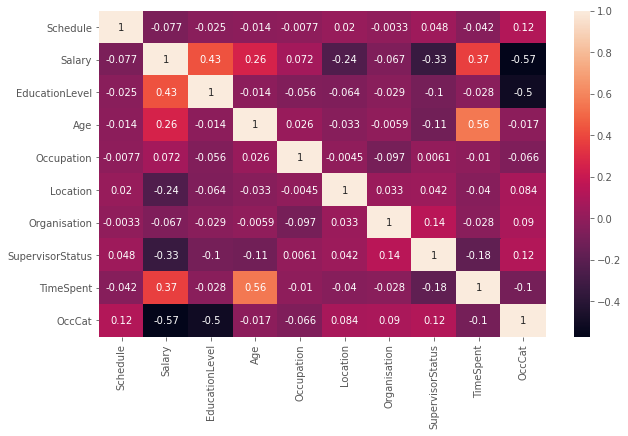

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
[ 4  3  5  2  6  7  8  9 10  1  0]


In [33]:
corr = cleaned.corr()
sn.heatmap(corr, annot=True)
plt.show()

print(list(string.ascii_uppercase))
print(cleaned["Age"].unique())

# Hypothesis Testing
We think that the people we work part time are mostly students or older people who gain a lot more per hour and so they can afford to work less, or have kids to look after. And so we expect to have a lot less young people working full time, and to see the number of full time decrease after a certain age.

To test our hypothesis we will first plot the two population and perform a t-test to check if the two population means are different.

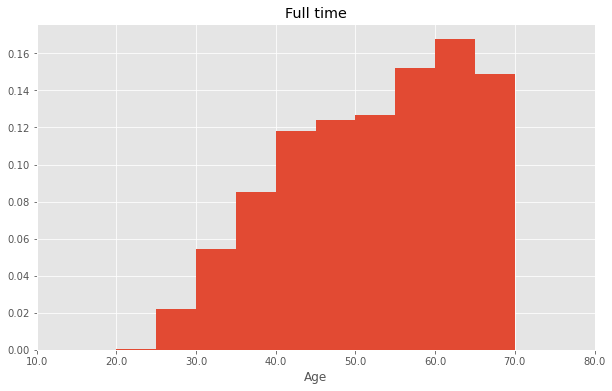

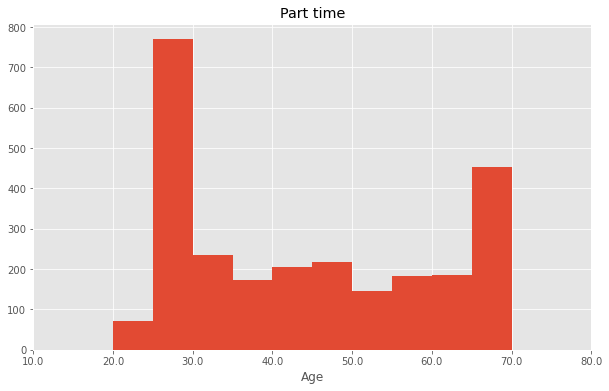

In [6]:
# Hypothese Testing, are there more young people doing full times? 
schedule = cleaned[['Schedule', 'Age']]
fullTime = schedule[schedule['Schedule'] == 1]
partTime = schedule[schedule['Schedule'] == 2]

groupedFull = fullTime.groupby('Age')
groupedPart = partTime.groupby('Age')

npFullTime = fullTime['Age'].to_numpy()
npPartTime = partTime['Age'].to_numpy()

bins=np.arange(len(groupedFull)) # number of different age category

plt.hist(npFullTime, bins=bins, density=True)
plt.title('Full time')
plt.xlabel('Age')
locs, labels = plt.xticks()
labels = [float(item)*5+20 for item in locs]
plt.xticks(locs, labels)
plt.show()

plt.hist(npPartTime, bins=bins)
plt.title('Part time')
locs, labels = plt.xticks()
labels = [float(item)*5+20 for item in locs]
plt.xticks(locs, labels)
plt.xlabel('Age')
plt.show()

In the first histogram we can see that most of the people working full time are older than 40, and the number of full time increases with the age, expect from 65 to 70 where there is a small decrease.

While in the second graph, we can see two spikes, the first one a 25 and the second one at 65 and between the spikes the number of part time workes is stable. 

Those two observations go in the same way as our hypothesis, but let's perform a t-test to be sure there is a significance difference between the two populations.

In [10]:
# Compute the means of the two population 
fullAge = fullTime['Age']
partAge = partTime['Age']

print(f'full time age mean: {fullAge.mean()*5+20}')
print(f'part time age mean: {partAge.mean()*5+20}')
print()

# Now we can compare the two means
# H_0 our means are equal and H_a our means are different, with a significance value of 1%
from scipy.stats import ttest_ind

t, pval = ttest_ind(fullAge, partAge)
pval = float(pval)
print(f't value: {t}')
print(f'we reject the null hypothesis with a p value smaller than 1%' if pval < 0.01 else f'we accept H_0 with a p value bigger than 1% {pval}')


full time age mean: 50.17074734687154
part time age mean: 42.086330935251794

t value: 35.83115868068887
we reject the null hypothesis with a p value smaller than 1%


After performing our t-test we have a very small p-value, which implies a strong evidence against the null hypothesis and confirms that the two population are different. 

# What influences the salary?

From the EDA we can see that there is a big correlation between the Eduction level, age, time spent. Then there is Occupation who has a positve correlation and the remaining attributes have a negative correlation. In order to facilitate the reading we fit a linear regression model through the data. 

0.1813535839560093


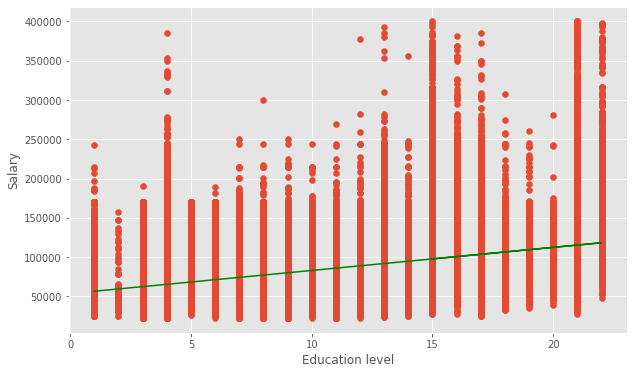

0.14530764391481588


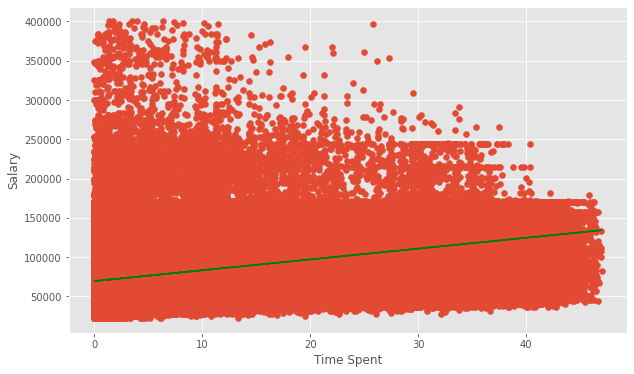

0.06985164527213028


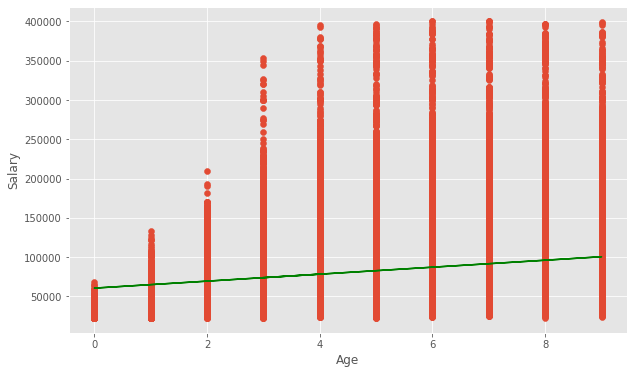

In [37]:
plt.scatter(x=cleaned["EducationLevel"], y=cleaned["Salary"])
model = sm.ols(formula="Salary ~ EducationLevel", data=cleaned).fit()
print(model.rsquared)
plt.plot(cleaned["EducationLevel"], model.predict(), color="g")
plt.xlabel("Education level")
plt.ylabel("Salary")
plt.show()

plt.scatter(x=cleaned["TimeSpent"], y=cleaned["Salary"])
model = sm.ols(formula="Salary ~ TimeSpent", data=cleaned).fit()
print(model.rsquared)
plt.plot(cleaned["TimeSpent"], model.predict(), color="g")
plt.xlabel("Time Spent")
plt.ylabel("Salary")
plt.show()

plt.scatter(x=cleaned["Age"], y=cleaned["Salary"])
model = sm.ols(formula="Salary ~ Age", data=cleaned).fit()
print(model.rsquared)
plt.plot(cleaned["Age"], model.predict(), color="g")
plt.xlabel("Age")
plt.ylabel("Salary")
plt.show()

Now, as we can see from the graphs the more a person is educated, has spent time at the "company" and is old, the salary increases as well. However, from the $R^2$ value we see that using only one of these to predict the salary is not enough. From this analysis we were wondering since the amount of time you spent at the company has an influence on how much you get paied, is this also the reason the people stay? 

## Can the salary be a reason why people stay?

From the correlation map we can see that the age has a big influence on how long someone stays at the company (~0.56) and then comes age with a correlation of 0.36. This already gives a hint at the outcome. 

                            OLS Regression Results                            
Dep. Variable:              TimeSpent   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                 2.055e+05
Date:                Tue, 23 Mar 2021   Prob (F-statistic):               0.00
Time:                        13:41:43   Log-Likelihood:            -4.3940e+06
No. Observations:             1208487   AIC:                         8.788e+06
Df Residuals:                 1208485   BIC:                         8.788e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0984      0.022    142.242      0.0

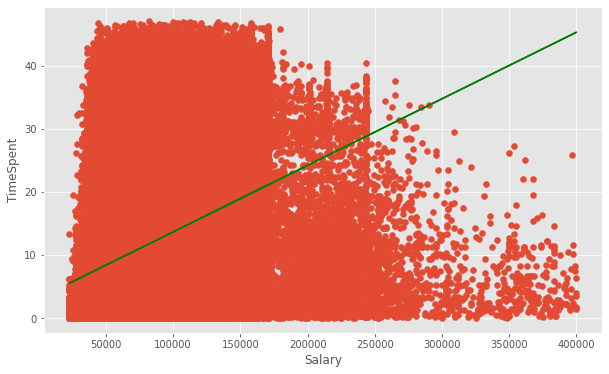

In [39]:
plt.scatter(x=cleaned["Salary"], y=cleaned["TimeSpent"])
model = sm.ols(formula="TimeSpent ~ Salary", data=cleaned).fit()
print(model.summary())
plt.plot(cleaned["Salary"], model.predict(), color="g")
plt.xlabel("Salary")
plt.ylabel("TimeSpent")
plt.show()

From the linear regression we can see that the salary does come into acount has it has an $R^2$ score of 0.145.

## Model used to try to predict how much someone gets paied

Based on what we know, only Time spent, Education level and Age have an influence on how the salary increases. Because we have two categorical data, we will implement a random forest regressor we will then test again a linear regressor. 

In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

X_train, X_test, y_train, y_test = train_test_split(cleaned[["Age", "TimeSpent", "EducationLevel"]],cleaned["Salary"],test_size=0.1, random_state=0)  
X_non_test = np.vstack((X_train, X_test))
y_non_test = np.hstack((y_train, y_test))
    
regr = RandomForestRegressor(random_state=0)

kf = KFold(n_splits=5)
kf.get_n_splits(X_train)

val_accs = []
mses = []

for train_index, test_index in kf.split(X_non_test):
    X_train, X_test = X_non_test[train_index], X_non_test[test_index]
    y_train, y_test = y_non_test[train_index], y_non_test[test_index]

    regr.fit(X_train, y_train)
    val_accs.append(regr.score(X_test, y_test))
    pred = regr.predict(X_test)

    mses.append(mean_squared_error(y_test, pred))

print("Mean squared error: ",mses)
print("Accs over the 5-folds: ", val_accs)

Mean squared error:  [754418388.857222, 758576690.3249302, 757758061.4550474, 751927860.6469792, 756370606.0188534]
Accs over the 5-folds:  [0.4135312763605188, 0.41333960051877894, 0.4113769096976855, 0.41428335413778594, 0.4117564632408912]


In [77]:
print(np.mean(mses))
print(np.mean(val_accs))

755810321.4606063
0.4128575207911321


Random Forest performs quite badly as it has a huge mean squared error (~755810321.4606063) and a mean accuracy of 0.4128575207911321 with no real difference in error or accuracy over the different folds.